In [62]:
import os
import json

import matplotlib.pyplot as plt
from dataclasses import dataclass
import numpy as np

In [63]:
this_dir = os.path.dirname(os.path.abspath(''))
# results is in "../results"
results_dir = os.path.join(this_dir, "results")

In [64]:
experiment_folder = "casestudy_example"
experiment_name = "cs_example_edf"

experiment_file = os.path.join(results_dir, experiment_folder, experiment_name + ".json")
if not os.path.exists(experiment_file):
    print("Experiment file not found: ", experiment_file)

In [65]:
with open(experiment_file) as f:
    experiment_data_raw = json.load(f)

In [66]:
def pre_process_data(data):
  for record in data:
    record["time"] = int(record["time"])

  min_time = min([record["time"] for record in data])
  for record in data:
    record["time"] -= min_time
    record["time"] /= (1000 * 1000)

    if record["entry"]["operation"] == "next_deadline":
      print("Record: ", record)
      record["entry"]["deadline"] = int(record["entry"]["deadline"])
      record["entry"]["deadline"] -= min_time
      record["entry"]["deadline"] /= (1000 * 1000)

  # data = sorted(data, key=lambda x: x["time"])
  return data

experiment_data = pre_process_data(experiment_data_raw)

print("Number of records: ", len(experiment_data))
print("First record: ", experiment_data[0])
operation_types = list(set([record["entry"]["operation"] for record in experiment_data]))
print("Operation types: ", operation_types)

Record:  {'entry': {'operation': 'next_deadline', 'chain_id': 0, 'deadline': 7146948, 'on_time': 1, 'time_diff': -73, 'periods_late': 0, 'thread_id': 1}, 'time': 0.000127}
Record:  {'entry': {'operation': 'next_deadline', 'chain_id': 1, 'deadline': 7146948, 'on_time': 1, 'time_diff': 0, 'periods_late': 0, 'thread_id': 0}, 'time': 0.0002}
Record:  {'entry': {'operation': 'next_deadline', 'chain_id': 0, 'deadline': 7147048, 'on_time': 1, 'time_diff': -71, 'periods_late': 0, 'thread_id': 1}, 'time': 0.000229}
Record:  {'entry': {'operation': 'next_deadline', 'chain_id': 0, 'deadline': 7147148, 'on_time': 1, 'time_diff': -157, 'periods_late': 0, 'thread_id': 0}, 'time': 0.000243}
Record:  {'entry': {'operation': 'next_deadline', 'chain_id': 1, 'deadline': 7147048, 'on_time': 1, 'time_diff': 0, 'periods_late': 0, 'thread_id': 1}, 'time': 0.0003}
Record:  {'entry': {'operation': 'next_deadline', 'chain_id': 1, 'deadline': 7147148, 'on_time': 1, 'time_diff': -57, 'periods_late': 0, 'thread_id

In [67]:
@dataclass
class Record:
  start_time: float
  end_time: float
  node_name: str

@dataclass
class RecordLine:
  node_name: str
  count: int

  def __eq__(self, other):
    return self.node_name == other.node_name and self.count == other.count

  def __hash__(self):
    return hash((self.node_name, self.count))

def get_records(data) -> list[Record]:
  # used to match start_work and end_work records
  current_records: dict[RecordLine, Record] = {}
  records = []
  for record in data:
    if record["entry"]["operation"] == "start_work":
      current_record = Record(start_time=record["time"], node_name=record["entry"]["node"], end_time=None)
      current_record_line = RecordLine(node_name=record["entry"]["node"], count=record["entry"]["count"])
      if current_record_line in current_records:
        raise Exception("Overlapping records")
      current_records[current_record_line] = current_record
    elif record["entry"]["operation"] == "end_work":
      current_record_line = RecordLine(node_name=record["entry"]["node"], count=record["entry"]["count"])
      if current_record_line not in current_records:
        raise Exception("No start record")
      current_record = current_records[current_record_line]
      current_record.end_time = record["time"]
      records.append(current_record)
      del current_records[current_record_line]
  return records

records = get_records(experiment_data)

In [68]:
num_nodes = len(set([record.node_name for record in records]))
print("Number of nodes: ", num_nodes)

Number of nodes:  4


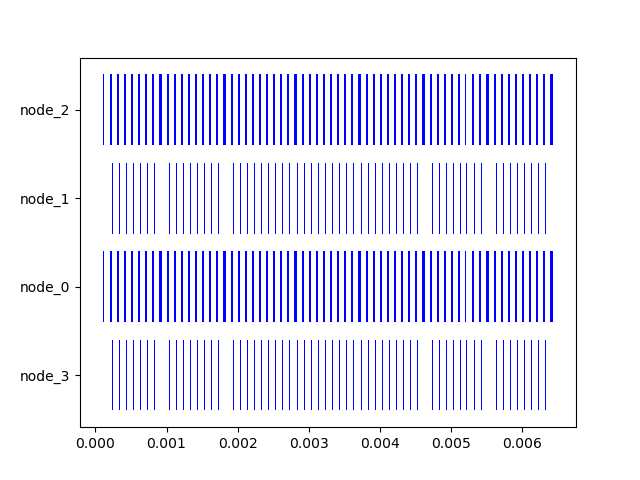

In [69]:
%matplotlib widget

# swimlane plot
name_to_id = {name: i for i, name in enumerate(set([record.node_name for record in records]))}
fig, ax = plt.subplots()
for i, record in enumerate(records):
  # ax.plot([record.start_time, record.end_time], [name_to_id[record.node_name], name_to_id[record.node_name]], label=record.node_name)
  ax.broken_barh([(record.start_time, record.end_time - record.start_time)], (name_to_id[record.node_name] - 0.4, 0.8), facecolors='blue')
ax.set_yticks(range(num_nodes))
ax.set_yticklabels(name_to_id.keys())
plt.show()

In [70]:
@dataclass
class Deadline:
    chain_id: int
    deadline: float
    on_time: bool

def get_deadlines(data) -> list[Deadline]:
    deadlines = []
    for record in data:
        if record["entry"]["operation"] == "next_deadline" and "on_time" in record["entry"]:
            deadlines.append(Deadline(chain_id=record["entry"]["chain_id"], deadline=record["entry"]["deadline"], on_time=record["entry"]["on_time"]))
    return deadlines

deadlines = get_deadlines(experiment_data)

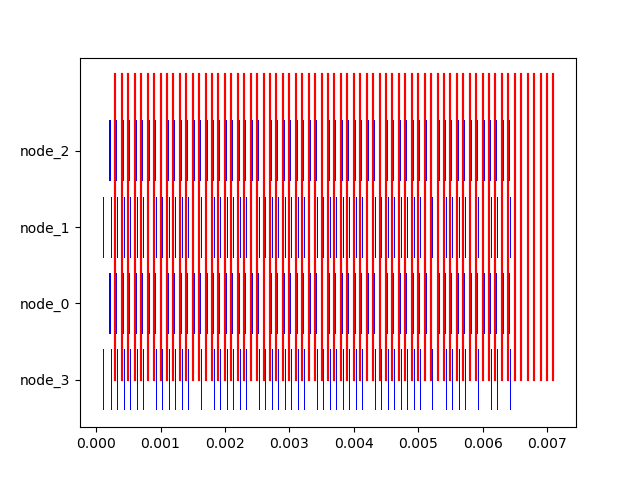

In [ ]:
# plot with lines for deadlines
fig, ax = plt.subplots()
for i, record in enumerate(records):
  ax.broken_barh([(record.start_time, record.end_time - record.start_time)], (name_to_id[record.node_name] - 0.4, 0.8), facecolors='blue')

# draw a vertical line for each deadline
for deadline in deadlines:
    # may have to adjust the y value depending on your chain layout
    ax.plot([deadline.deadline, deadline.deadline], [0, num_nodes], color='red')

ax.set_yticks(range(num_nodes))
ax.set_yticklabels(name_to_id.keys())
plt.show()
